<table class="ee-notebook-buttons" align="left">
    <td>
        <a target="_parent" href="https://colab.research.google.com/github/Deode22/ee-ndvi-animation/blob/main/notebook/Series_NDVI.ipynb">
            <img width=26px src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab
        </a>
    </td>
</table>

---

# Uso de Prophet con el NDVI de una región en España

## Introducción

Este notebook presenta un análisis predictivo del Índice de Vegetación de Diferencia Normalizada (NDVI) en la región de Molina de Aragón. El NDVI es un indicador clave para monitorear la salud y el vigor de la vegetación.

### Objetivos
- Analizar las series temporales históricas del NDVI en la región
- Implementar un modelo predictivo utilizando Prophet (Meta)
- Evaluar patrones estacionales y tendencias en la dinámica de la vegetación
- Generar predicciones futuras del NDVI

### Metodología
Utilizaremos Prophet, una herramienta robusta para el análisis de series temporales, que nos permitirá:
- Manejar la estacionalidad inherente a los datos de vegetación
- Incorporar efectos de tendencias a largo plazo
- Considerar posibles cambios en los patrones debido a factores climáticos

### Librerías necesarias (Básicas)
```python
import ee # Parea extraer la información satelital
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
```


---

## Preparación de los datos. Recopilación y preproceso

In [9]:
import ee
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Inicializar Earth Engine
ee.Authenticate()
ee.Initialize(project = '')

Establezco un área de estudio, cerca de Molina de Aragón. También establezco las fechas.

In [3]:
# Definir el área de interés (bbox)
roi = ee.Geometry.Rectangle([-2.139161, 40.765660, -2.115560, 40.775994])

# Calcular fecha inicial
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)

### Funciones

Verifico que los datos existan

In [36]:
def check_data_availability():
    """
    Función de diagnóstico para verificar la disponibilidad de imágenes
    y los valores de NDVI calculados.
    """
    # Obtener colección para el último año
    collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2014-01-01', '2023-12-31') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

    # Verificar número de imágenes
    count = collection.size().getInfo()
    print(f"Número de imágenes encontradas: {count}")

    if count > 0:
        # Calcular NDVI para la primera imagen como prueba
        first_image = ee.Image(collection.first())
        ndvi = first_image.normalizedDifference(['B8', 'B4']).rename('NDVI')

        # Calcular estadísticas para esta imagen
        stats = ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=10,
            maxPixels=1e9
        ).getInfo()

        print("\nEstadísticas de prueba de NDVI:")
        print(f"Valor medio de NDVI: {stats.get('NDVI')}")

        # Obtener fechas de las imágenes
        dates = collection.aggregate_array('system:time_start').getInfo()
        dates = [datetime.fromtimestamp(d/1000).strftime('%Y-%m-%d') for d in dates]

        print("\nPrimeras 5 fechas disponibles:")
        for date in dates[:5]:
            print(date)

    return count

print("Iniciando verificación de datos...")
num_images = check_data_availability()

Iniciando verificación de datos...
Número de imágenes encontradas: 254

Estadísticas de prueba de NDVI:
Valor medio de NDVI: 0.4626675843564199

Primeras 5 fechas disponibles:
2015-07-29
2015-07-29
2015-07-29
2015-08-18
2015-08-18


Y muestro como es la zona de estudio:

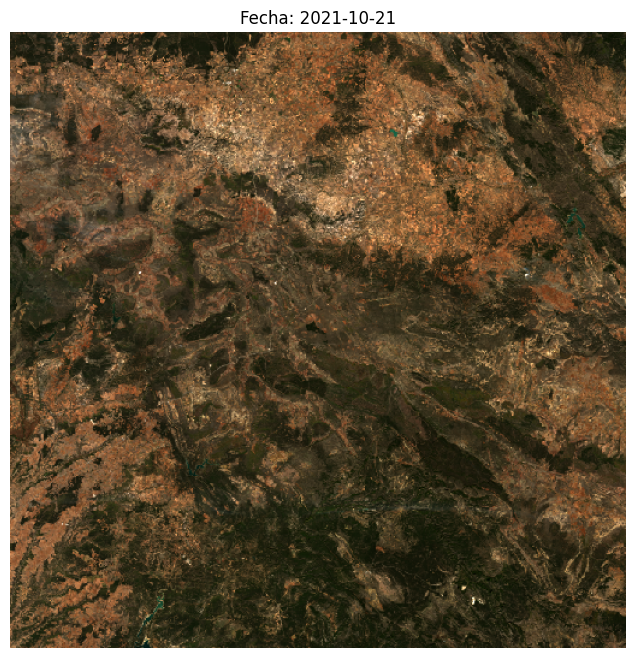

In [52]:
import requests
from io import BytesIO

def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

def get_s2_image(date_str, margin_days=5):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    start_date = (date - timedelta(days=margin_days)).strftime('%Y-%m-%d')
    end_date = (date + timedelta(days=margin_days)).strftime('%Y-%m-%d')

    s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(roi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .sort('CLOUDY_PIXEL_PERCENTAGE'))

    count = s2_collection.size().getInfo()
    if count == 0:
        print(f"No hay imágenes disponibles para el período {start_date} a {end_date}")
        return None, None

    image = s2_collection.first()

    # Calcular NDVI
    image_with_ndvi = calculate_ndvi(image)
    mean_ndvi = image_with_ndvi.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10
    ).get('NDVI').getInfo()

    return image, mean_ndvi

def get_image_array(image):
    if image is None:
        return None

    visualization = {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 3000,
        'dimensions': [512, 512]
    }

    url = image.getThumbURL(visualization)
    response = requests.get(url)
    img_data = plt.imread(BytesIO(response.content))

    return img_data

def plot_first_sentinel_image(date='2021-10-21'):
   image, mean_ndvi = get_s2_image(date)
   img_array = get_image_array(image)

   plt.figure(figsize=(12, 8))
   if img_array is not None:
       plt.imshow(img_array)
       plt.title(f'Fecha: {date}')
       if mean_ndvi is not None:
           plt.xlabel(f'NDVI: {mean_ndvi:.3f}')
   else:
       plt.text(0.5, 0.5, f'No hay imagen disponible para {date}',
               ha='center', va='center')
   plt.axis('off')
   plt.show()

plot_first_sentinel_image()

Defino las funciones para recopilar los datos

In [ ]:
def get_ndvi_series():
    s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(roi)
        .filterDate('2014-01-01', datetime.now().strftime('%Y-%m-%d'))
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    def calculate_ndvi(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
        stats = ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=10,
            maxPixels=1e9
        ).getInfo()
        return {
            'fecha': date,
            'ndvi': stats.get('NDVI')
        }

    images = s2_collection.toList(s2_collection.size().getInfo())
    resultados = []

    for i in range(images.size().getInfo()):
        try:
            image = ee.Image(images.get(i))
            resultado = calculate_ndvi(image)
            if resultado['ndvi'] is not None:
                resultados.append(resultado)
        except Exception as e:
            print(f"Error: {str(e)}")

    return pd.DataFrame(resultados)

### NDVI

Recopilo los datos. AVISO: Toma tiempo

In [ ]:
df_ndvi = get_ndvi_series()
df_ndvi = df_ndvi.sort_values('fecha')
df_ndvi.to_csv('ndvi_serie_temporal.csv', index=False)
print("\nPrimeras 5 mediciones:")
print(df_ndvi.head())
print(f"\nTotal de mediciones: {len(df_ndvi)}")


Primeras 5 mediciones:
        fecha      ndvi
0  2017-04-09  0.632860
1  2017-04-19  0.539341
2  2017-05-19  0.627484
3  2017-06-18  0.618584
4  2017-07-18  0.539058

Total de mediciones: 207


---

---

## Pre - análisis

Con los datos descargados, miro como están y un poco su estadíistica descriptiva

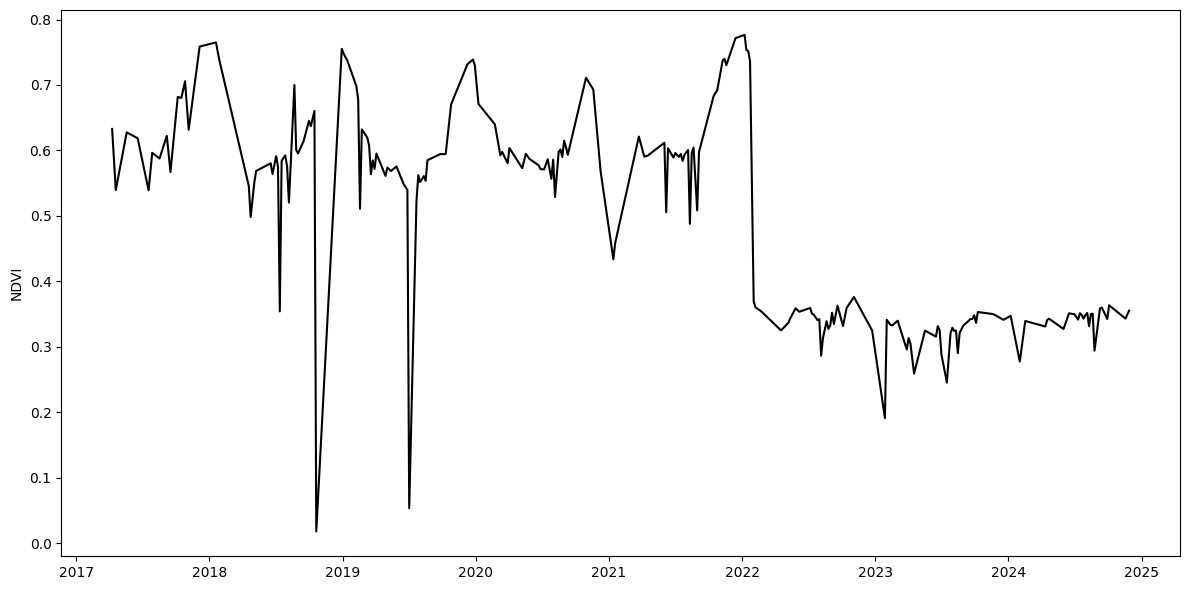

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ndvi_path = '/content/drive/MyDrive/Algortimos/Prophet (Meta)/'
df_ndvi = pd.read_csv(ndvi_path + 'ndvi_serie_temporal.csv')
df_ndvi['fecha'] = pd.to_datetime(df_ndvi['fecha'])

plt.figure(figsize=(12, 6), dpi = 100)
sns.lineplot(data=df_ndvi, x='fecha', y='ndvi', errorbar=None, color = 'black')

plt.xlabel('')
plt.ylabel('NDVI')

plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.tight_layout()

Voy a poner flechas a las fechas problematicas

Caídas significativas en el NDVI:
Fecha: 2018-10-21, NDVI: 0.018, Caída: -0.643
Fecha: 2019-07-03, NDVI: 0.053, Caída: -0.486
Fecha: 2022-02-02, NDVI: 0.369, Caída: -0.367


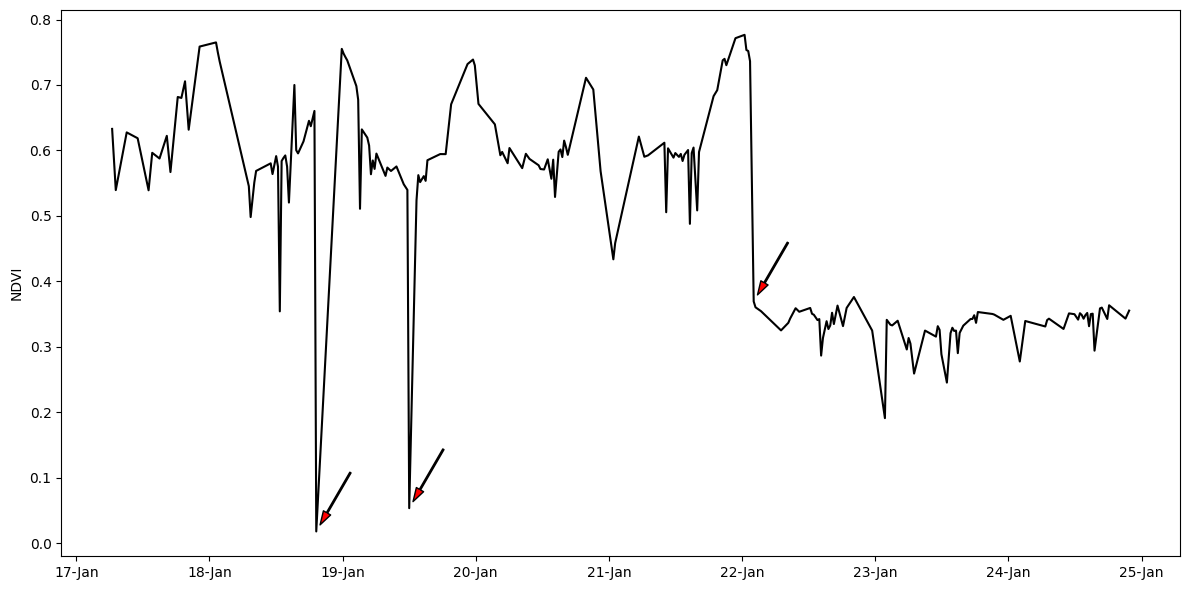

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calcular las diferencias entre puntos consecutivos
df_ndvi['diff'] = df_ndvi['ndvi'].diff()

# Definir un umbral para considerar una caída significativa
threshold = -0.3

# Encontrar los puntos donde hay caídas significativas
drops = df_ndvi[df_ndvi['diff'] < threshold]

# Crear el gráfico base
plt.figure(figsize=(12, 6), dpi=100)
sns.lineplot(data=df_ndvi, x='fecha', y='ndvi', errorbar=None, color='black')

# Añadir flechas para cada caída significativa
offset_x = np.timedelta64(-2500, 'h')  # offset horizontal
offset_y = 0.1  # offset vertical

for _, row in drops.iterrows():
    plt.annotate('',
                xy=(row['fecha'], row['ndvi']),  # punto final de la flecha
                xytext=(row['fecha'] - offset_x, row['ndvi'] + offset_y),  # punto inicial de la flecha
                arrowprops=dict(facecolor='red',
                              shrink=0.1,
                              width=1,
                              headwidth=6,
                              headlength=10),
                )

plt.xlabel('')
plt.ylabel('NDVI')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%y-%b'))

plt.tight_layout()

# Mostrar los valores de las caídas
print("Caídas significativas en el NDVI:")
for _, row in drops.iterrows():
    print(f"Fecha: {row['fecha'].strftime('%Y-%m-%d')}, NDVI: {row['ndvi']:.3f}, Caída: {row['diff']:.3f}")

Tengo dos puntos raros y una caída. Voy a ver que son:

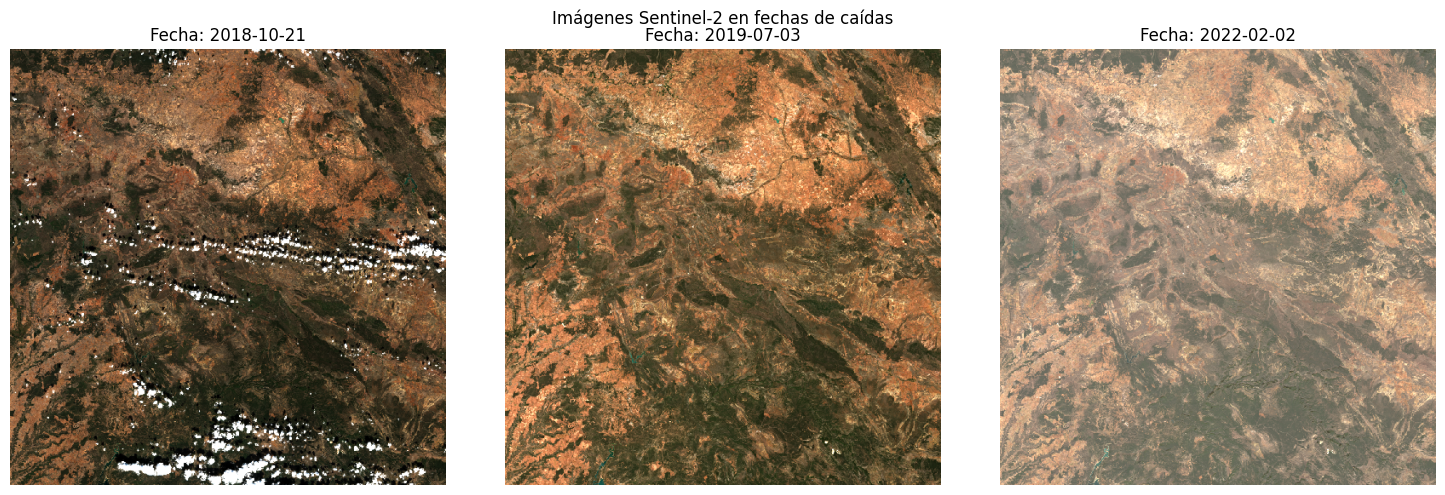

Para la fecha solicitada 2018-10-21, se encontró imagen del: 2018-10-16
NDVI medio: 0.660
---
Para la fecha solicitada 2019-07-03, se encontró imagen del: 2019-06-28
NDVI medio: 0.540
---
Para la fecha solicitada 2022-02-02, se encontró imagen del: 2022-02-02
NDVI medio: 0.369
---


In [ ]:
import ee
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Inicializar GEE
ee.Initialize()

# Definir el área de interés (bbox)
roi = ee.Geometry.Rectangle([-2.139161, 40.765660, -2.115560, 40.775994])


# Fechas de las caídas significativas
dates = ['2018-10-21', '2019-07-03', '2022-02-02']

# Crear subplots
fig, axes = plt.subplots(1, len(dates), figsize=(15, 5))
if len(dates) == 1:
    axes = [axes]
fig.suptitle('Imágenes Sentinel-2 en fechas de caídas')

for i, date in enumerate(dates):
    image, mean_ndvi = get_s2_image(date)
    img_array = get_image_array(image)

    if img_array is not None:
        axes[i].imshow(img_array)
        axes[i].set_title(f'Fecha: {date}')
        if mean_ndvi is not None:
            axes[i].set_xlabel(f'NDVI: {mean_ndvi:.3f}')
    else:
        axes[i].text(0.5, 0.5, f'No hay imagen\ndisponible para\n{date}',
                    ha='center', va='center')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Imprimir las fechas exactas de las imágenes encontradas y sus NDVI
for date in dates:
    image, mean_ndvi = get_s2_image(date)
    if image is not None:
        actual_date = image.date().format('YYYY-MM-dd').getInfo()
        print(f"Para la fecha solicitada {date}, se encontró imagen del: {actual_date}")
        print(f"NDVI medio: {mean_ndvi:.3f}")
        print("---")
    else:
        print(f"No se encontró imagen para la fecha {date}")
        print("---")

Veo que las dos primeras son datos **atípicos**. La tercera, la caída que no remonta, esta ligado a que la imagen se ve mas nublada...

No se si será por la imagen que no está todo normalizado... o no se

No hay imágenes disponibles para el período 2022-10-16 a 2022-10-26


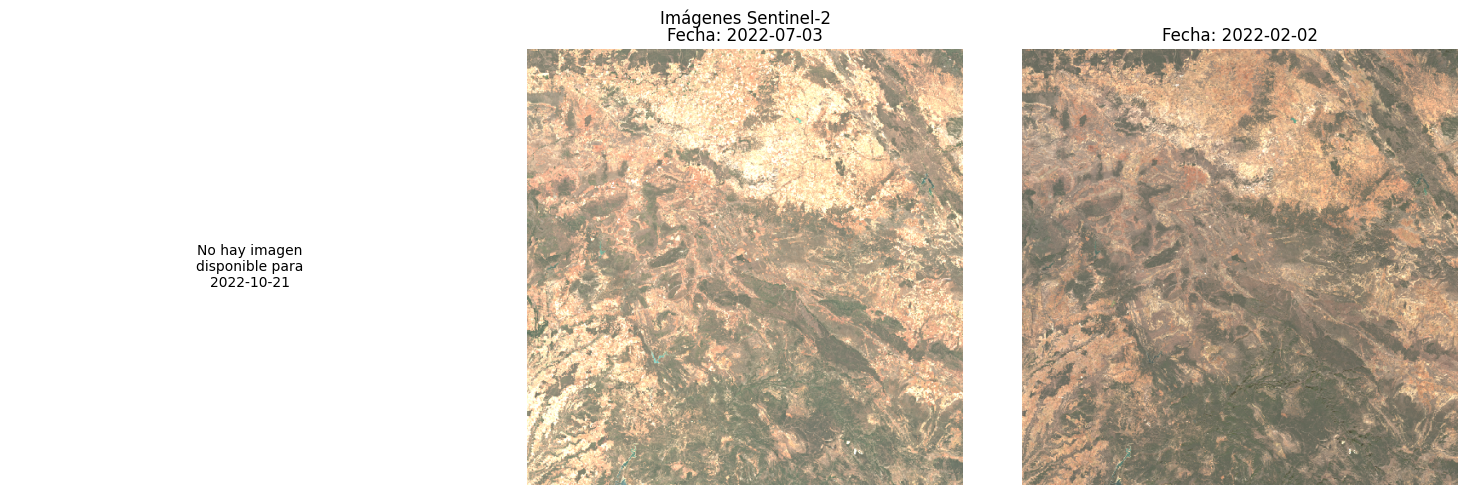

No hay imágenes disponibles para el período 2022-10-16 a 2022-10-26
No se encontró imagen para la fecha 2022-10-21
---
Para la fecha solicitada 2022-07-03, se encontró imagen del: 2022-07-07
NDVI medio: 0.359
---
Para la fecha solicitada 2022-02-02, se encontró imagen del: 2022-02-02
NDVI medio: 0.369
---


In [ ]:
import ee
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Inicializar GEE
ee.Initialize()

# Definir el área de interés (bbox)
roi = ee.Geometry.Rectangle([-2.139161, 40.765660, -2.115560, 40.775994])

def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

def get_s2_image(date_str, margin_days=5):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    start_date = (date - timedelta(days=margin_days)).strftime('%Y-%m-%d')
    end_date = (date + timedelta(days=margin_days)).strftime('%Y-%m-%d')

    s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(roi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .sort('CLOUDY_PIXEL_PERCENTAGE'))

    count = s2_collection.size().getInfo()
    if count == 0:
        print(f"No hay imágenes disponibles para el período {start_date} a {end_date}")
        return None, None

    image = s2_collection.first()

    # Calcular NDVI
    image_with_ndvi = calculate_ndvi(image)
    mean_ndvi = image_with_ndvi.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10
    ).get('NDVI').getInfo()

    return image, mean_ndvi

def get_image_array(image):
    if image is None:
        return None

    visualization = {
        'bands': ['B4', 'B3', 'B2'],
        'min': 0,
        'max': 3000,
        'dimensions': [512, 512]
    }

    url = image.getThumbURL(visualization)
    response = requests.get(url)
    img_data = plt.imread(BytesIO(response.content))

    return img_data

# Fechas de las caídas significativas
dates = ['2022-10-21', '2022-07-03', '2022-02-02']

# Crear subplots
fig, axes = plt.subplots(1, len(dates), figsize=(15, 5))
if len(dates) == 1:
    axes = [axes]
fig.suptitle('Imágenes Sentinel-2')

for i, date in enumerate(dates):
    image, mean_ndvi = get_s2_image(date)
    img_array = get_image_array(image)

    if img_array is not None:
        axes[i].imshow(img_array)
        axes[i].set_title(f'Fecha: {date}')
        if mean_ndvi is not None:
            axes[i].set_xlabel(f'NDVI: {mean_ndvi:.3f}')
    else:
        axes[i].text(0.5, 0.5, f'No hay imagen\ndisponible para\n{date}',
                    ha='center', va='center')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Imprimir las fechas exactas de las imágenes encontradas y sus NDVI
for date in dates:
    image, mean_ndvi = get_s2_image(date)
    if image is not None:
        actual_date = image.date().format('YYYY-MM-dd').getInfo()
        print(f"Para la fecha solicitada {date}, se encontró imagen del: {actual_date}")
        print(f"NDVI medio: {mean_ndvi:.3f}")
        print("---")
    else:
        print(f"No se encontró imagen para la fecha {date}")
        print("---")

Efectivamente las imagenes están nubladas...

Quito los datos atipicos y reploteo:

In [ ]:
df_ndvi = df_ndvi[df_ndvi['ndvi'] >= 0.2]

Caídas significativas en el NDVI:
Fecha: 2022-02-02, NDVI: 0.369, Caída: -0.367


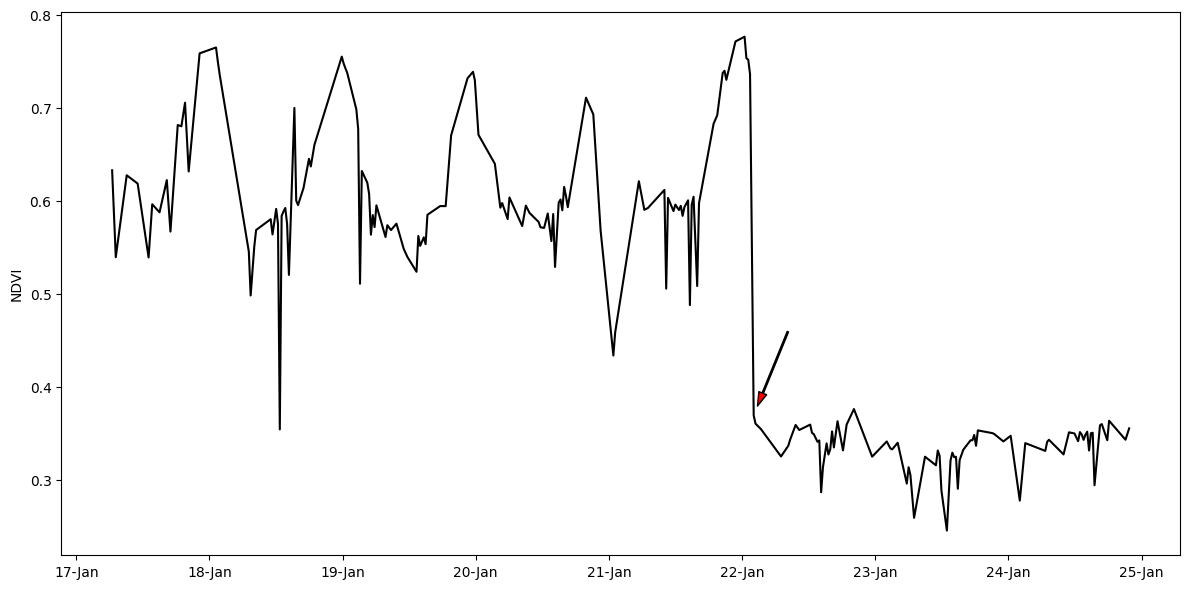

In [ ]:
# Definir un umbral para considerar una caída significativa
threshold = -0.3

# Encontrar los puntos donde hay caídas significativas
drops = df_ndvi[df_ndvi['diff'] < threshold]

# Crear el gráfico base
plt.figure(figsize=(12, 6), dpi=100)
sns.lineplot(data=df_ndvi, x='fecha', y='ndvi', errorbar=None, color='black')

# Añadir flechas para cada caída significativa
offset_x = np.timedelta64(-2500, 'h')  # offset horizontal
offset_y = 0.1  # offset vertical

for _, row in drops.iterrows():
    plt.annotate('',
                xy=(row['fecha'], row['ndvi']),  # punto final de la flecha
                xytext=(row['fecha'] - offset_x, row['ndvi'] + offset_y),  # punto inicial de la flecha
                arrowprops=dict(facecolor='red',
                              shrink=0.1,
                              width=1,
                              headwidth=6,
                              headlength=10),
                )

plt.xlabel('')
plt.ylabel('NDVI')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%y-%b'))

plt.tight_layout()

# Mostrar los valores de las caídas
print("Caídas significativas en el NDVI:")
for _, row in drops.iterrows():
    print(f"Fecha: {row['fecha'].strftime('%Y-%m-%d')}, NDVI: {row['ndvi']:.3f}, Caída: {row['diff']:.3f}")

A partir de aquí puedo ver si normalizando los datos o usando el **COPERNICUS HARMONIZED** tengo los datos reales. Probablemente, la caída de `0.367`sea la diferencia global de las imagenes.

Peeero, puedo usar `Prophet` para hacer predicciones

Para hacer las predicciones tendría que poner **datos de lluvia y temperatura** como regresores añadidos (`model.add_regressor()`), que están muy ligados al NDVI

---

# Preparación de datasets extra: tempereratura y lluvia


Primeros registros del DataFrame:
       fecha  temperatura  precipitacion
0 2017-01-01    -0.307092       0.013546
1 2017-01-02     0.577381       0.480995
2 2017-01-03     2.358944       0.087104
3 2017-01-04     3.551939       0.007376
4 2017-01-05     1.791509       0.041257

Estadísticas descriptivas:
                     fecha  temperatura  precipitacion
count                 2914  2914.000000    2914.000000
mean   2020-12-27 12:00:00    12.124019      20.264602
min    2017-01-01 00:00:00    -4.444781       0.000000
25%    2018-12-30 06:00:00     5.688614       0.027969
50%    2020-12-27 12:00:00    11.133190       1.739624
75%    2022-12-25 18:00:00    18.442938      17.092487
max    2024-12-23 00:00:00    29.479664     557.531832
std                    NaN     7.826100      47.985201

Datos guardados en 'datos_climaticos_2017_2024.csv'


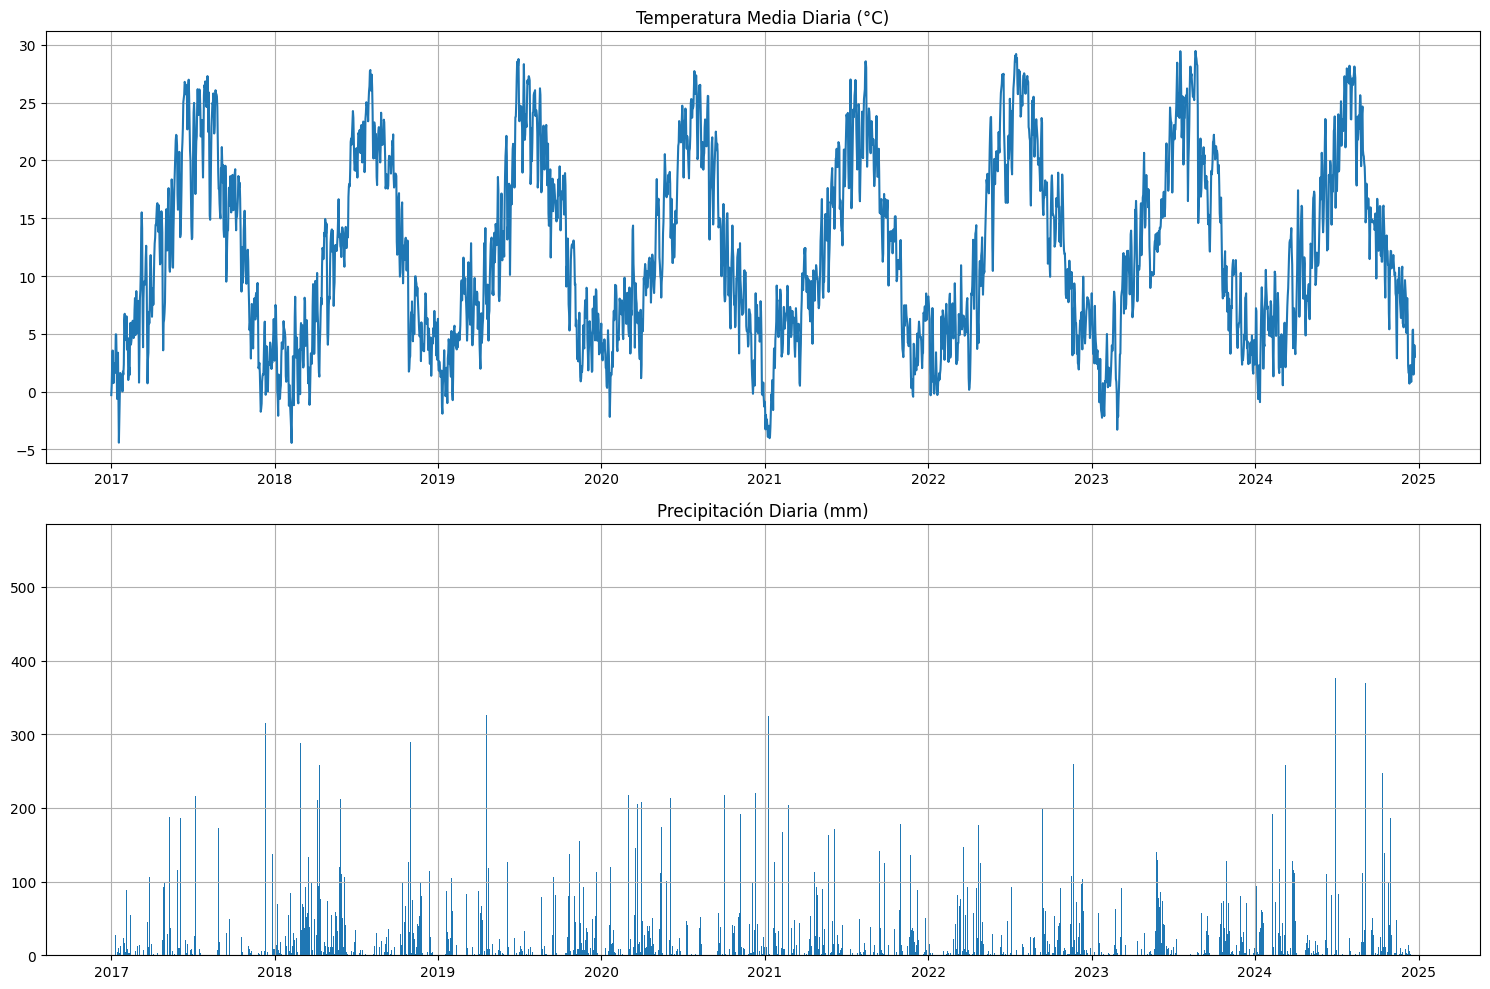

In [ ]:
import ee
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Inicializar GEE
ee.Initialize()

# Definir el área de interés (bbox)
roi = ee.Geometry.Rectangle([-2.139161, 40.765660, -2.115560, 40.775994])

# Función para obtener datos climáticos mensuales
def get_climate_data():
    # Colección ERA5-Land horaria
    collection = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')

    # Fechas
    start_date = '2017-01-01'
    end_date = datetime.now().strftime('%Y-%m-%d')

    # Función para calcular medias diarias
    def calculate_daily_means(date):
        date = ee.Date(date)
        daily_data = (collection
            .filterDate(date, date.advance(1, 'day'))
            .select(['temperature_2m', 'total_precipitation'])
            .mean())

        # Instead of using getInfo(), use the server-side ee.Algorithms.If()
        # to conditionally process the image based on the presence of bands.
        # This avoids client-side operations within the mapped function.
        def process_with_bands(image):
            # Convertir temperatura de Kelvin a Celsius
            image = image.addBands(
                image.select('temperature_2m').subtract(273.15).rename('temp_celsius'))

            # Multiplicar precipitación por 1000 (m a mm) y por 24 (convertir tasa horaria a diaria)
            image = image.addBands(
                image.select('total_precipitation').multiply(1000).multiply(24).rename('precip_mm'))

            return image.set('date', date.format('YYYY-MM-dd'))

        # If the image has bands, process it; otherwise, return None.
        processed_image = ee.Algorithms.If(daily_data.bandNames().size(),
                                          process_with_bands(daily_data),
                                          None)
        return processed_image

    # Generar lista de fechas
    dates = ee.List.sequence(
        ee.Date(start_date).millis(),
        ee.Date(end_date).millis(),
        1000 * 60 * 60 * 24  # Intervalo diario en milisegundos
    ).map(lambda millis: ee.Date(millis))

    # Calcular medias diarias, filtering out None values
    daily_collection = ee.ImageCollection(dates.map(calculate_daily_means)).filter(ee.Filter.neq('date', None))


    # Extraer datos para el ROI
    def extract_values(image):
        date = ee.Date(image.get('date'))
        means = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=11132  # Escala aproximada de ERA5-Land
        )
        return ee.Feature(None, {
            'date': date.format('YYYY-MM-dd'),
            'temp': means.get('temp_celsius'),
            'precip': means.get('precip_mm')
        })

    values = daily_collection.map(extract_values).getInfo()

    # Crear DataFrame
    data = []
    for feature in values['features']:
        props = feature['properties']
        data.append({
            'fecha': props['date'],
            'temperatura': props['temp'],
            'precipitacion': props['precip']
        })

    df = pd.DataFrame(data)
    df['fecha'] = pd.to_datetime(df['fecha'])
    return df.sort_values('fecha')

# Obtener datos
df_clima = get_climate_data()

# Visualizar primeros registros
print("\nPrimeros registros del DataFrame:")
print(df_clima.head())

# Estadísticas básicas
print("\nEstadísticas descriptivas:")
print(df_clima.describe())

# Guardar en CSV
df_clima.to_csv('datos_climaticos_2017_2024.csv', index=False)
print("\nDatos guardados en 'datos_climaticos_2017_2024.csv'")

# Visualización
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Temperatura
ax1.plot(df_clima['fecha'], df_clima['temperatura'])
ax1.set_title('Temperatura Media Diaria (°C)')
ax1.grid(True)

# Precipitación
ax2.bar(df_clima['fecha'], df_clima['precipitacion'], width=1)
ax2.set_title('Precipitación Diaria (mm)')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
df_clima.info()
display(df_clima)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 0 to 2913
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fecha          2914 non-null   datetime64[ns]
 1   temperatura    2914 non-null   float64       
 2   precipitacion  2914 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 68.4 KB


fecha  temperatura  precipitacion
0    2017-01-01    -0.307092       0.013546
1    2017-01-02     0.577381       0.480995
2    2017-01-03     2.358944       0.087104
3    2017-01-04     3.551939       0.007376
4    2017-01-05     1.791509       0.041257
...         ...          ...            ...
2909 2024-12-19     5.362123      28.194293
2910 2024-12-20     1.469891       2.744687
2911 2024-12-21     2.111695       0.005275
2912 2024-12-22     4.013788       0.095664
2913 2024-12-23     3.010680       0.916013

[2914 rows x 3 columns]

Implementamos en el dataframe con los valores de ndvi

In [ ]:
# Hacer el inner join
df = pd.merge(df_ndvi, df_clima,
                       on='fecha',
                       how='inner')

# Ordenar por fecha
df = df.sort_values('fecha')

df.to_csv(ndvi_path + 'ndvi_clima.csv', index = False)

# Uso de Prophet para predecir NDVI

In [ ]:
# Llamamos al df
ndvi_path = '/content/drive/MyDrive/Algortimos/Prophet (Meta)/'
df = pd.read_csv(ndvi_path + 'ndvi_clima.csv')
df['fecha'] = pd.to_datetime(df['fecha'])

display(df)
df.info()

fecha      ndvi      diff  temperatura  precipitacion
0   2017-04-09  0.632860       NaN    13.290755       0.008526
1   2017-04-19  0.539341 -0.093519    12.556685       0.542465
2   2017-05-19  0.627484  0.088143    10.719970      10.998565
3   2017-06-18  0.618584 -0.008899    26.296204       2.690987
4   2017-07-18  0.539058 -0.079526    25.820485      29.334428
..         ...       ...       ...          ...            ...
199 2024-09-14  0.359782  0.001224    13.592379       0.003493
200 2024-09-29  0.342415 -0.017367    12.956489       0.003046
201 2024-10-04  0.363348  0.020933    12.833097       0.006410
202 2024-11-18  0.342960 -0.020389    10.716030       2.775583
203 2024-11-28  0.355193  0.012233     5.558110       0.016274

[204 rows x 5 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fecha          204 non-null    datetime64[ns]
 1   ndvi           204 non-null    float64       
 2   diff           203 non-null    float64       
 3   temperatura    204 non-null    float64       
 4   precipitacion  204 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 8.1 KB


Quito los ndvi donde la imagen estaba mal:

In [ ]:
df_2022 = df[df['fecha'].dt.year >= 2022].reset_index(drop = True)
df_clean = df[df['fecha'].dt.year < 2022]

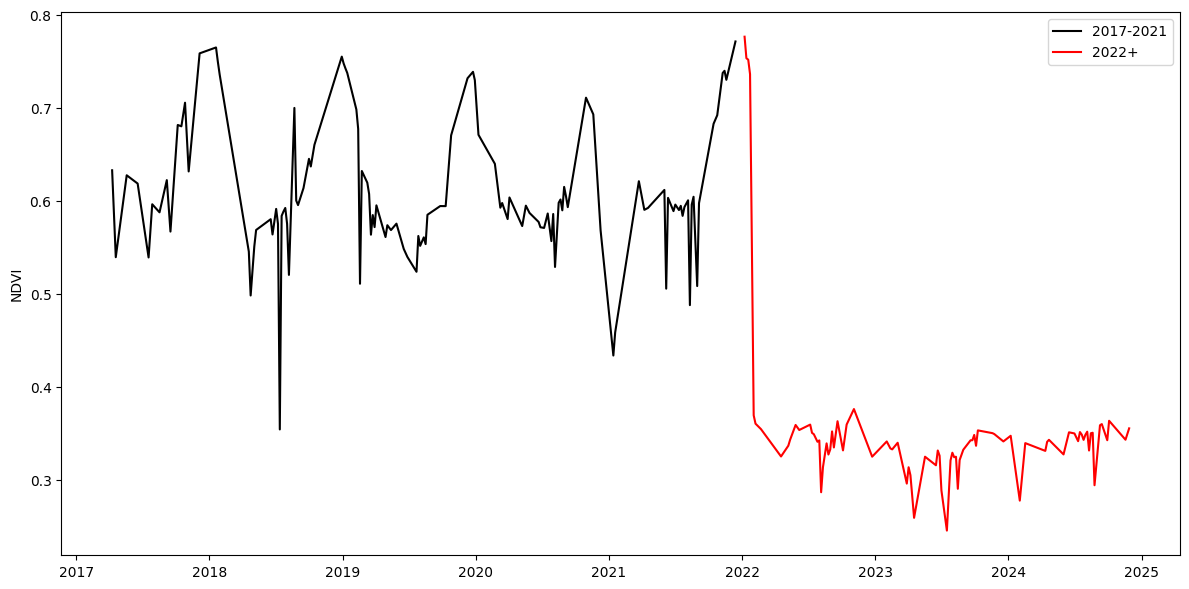

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)

# Línea para datos antes de 2022
sns.lineplot(data=df_clean, x='fecha', y='ndvi', errorbar=None, color='black', label='2017-2021')

# Línea para datos de 2022 en adelante
sns.lineplot(data=df_2022, x='fecha', y='ndvi', errorbar=None, color='red', label='2022+')

plt.xlabel('')
plt.ylabel('NDVI')

plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.legend()
plt.tight_layout()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1prt9col/ho9qt1ok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1prt9col/lm5eohq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30813', 'data', 'file=/tmp/tmp1prt9col/ho9qt1ok.json', 'init=/tmp/tmp1prt9col/lm5eohq7.json', 'output', 'file=/tmp/tmp1prt9col/prophet_modeljblkg1w4/prophet_model-20241229233359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:33:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


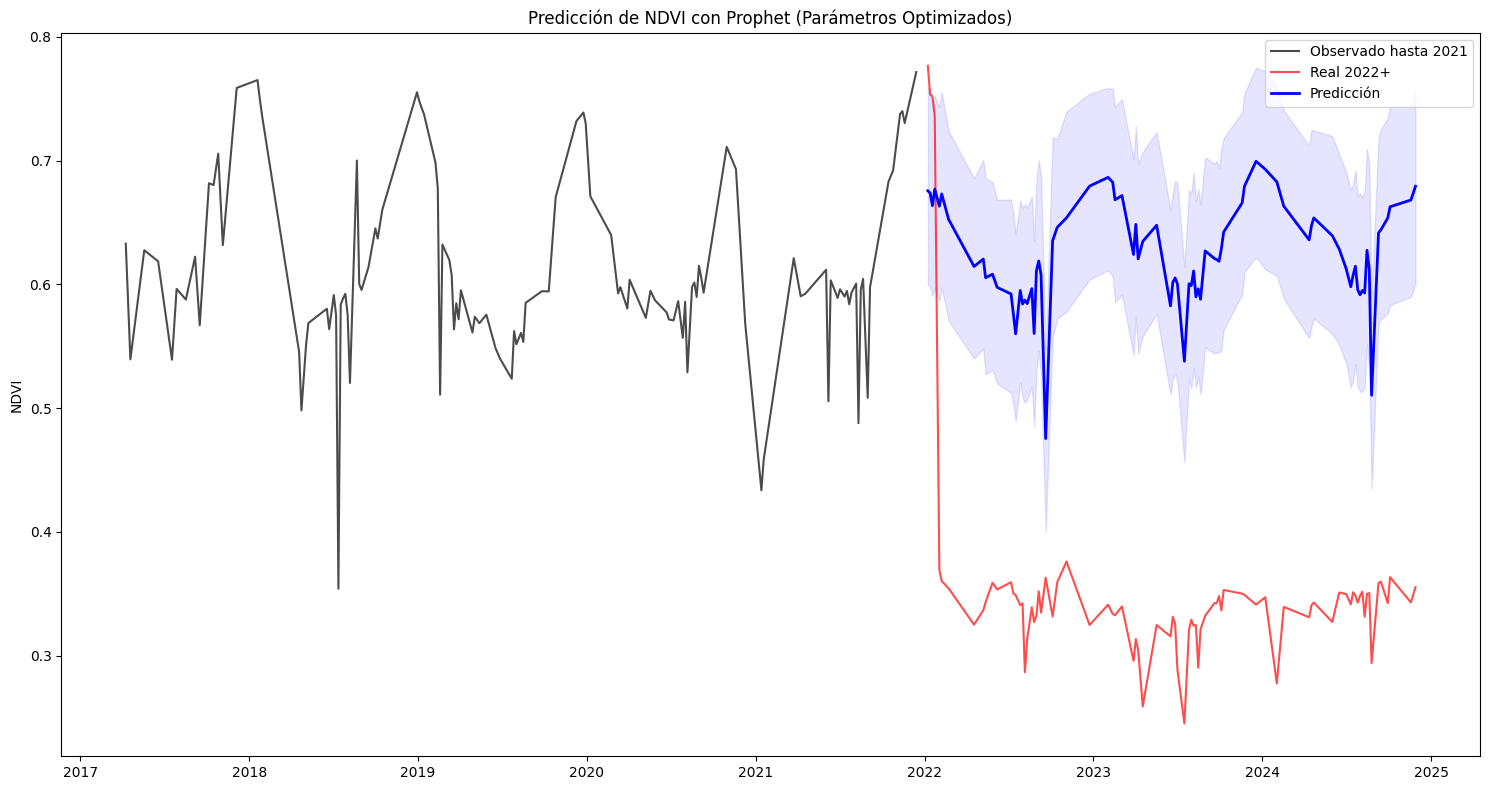

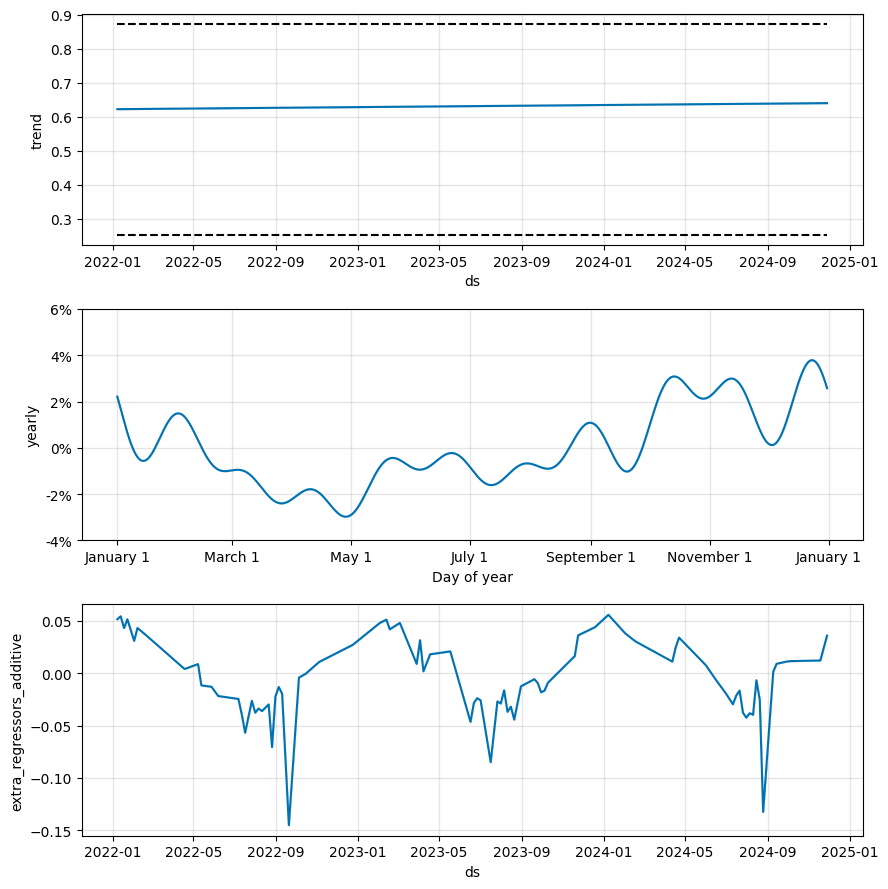

RMSE: 0.283
MAE: 0.277


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar los datos para Prophet
df_prophet = df_clean.copy()
df_prophet = df_prophet.rename(columns={'fecha': 'ds', 'ndvi': 'y'})
df_prophet = df_prophet.rename(columns={
    'temperatura': 'temp',
    'precipitacion': 'precip'
})

# Crear modelo con los parámetros optimizados
model = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=0.01,
    seasonality_mode='multiplicative',
    yearly_seasonality=10,
    weekly_seasonality=False,
    daily_seasonality=False,
    growth='logistic'
)

# Establecer límites basados en los datos históricos
df_prophet['cap'] = df_prophet['y'].max() + 0.1
df_prophet['floor'] = max(0, df_prophet['y'].min() - 0.1)

# Añadir los regresores
model.add_regressor('temp', mode='additive', prior_scale=0.03)
model.add_regressor('precip', mode='additive', prior_scale=0.03)

# Ajustar el modelo
model.fit(df_prophet)

# Crear dataframe futuro usando las fechas de df_2022
future = df_2022[['fecha', 'temperatura', 'precipitacion']].copy()
future = future.rename(columns={
    'fecha': 'ds',
    'temperatura': 'temp',
    'precipitacion': 'precip'
})

# Añadir límites al dataframe futuro
future['cap'] = df_prophet['cap'].iloc[0]
future['floor'] = df_prophet['floor'].iloc[0]

# Realizar predicciones
forecast = model.predict(future)

# Visualizar resultados
plt.figure(figsize=(15, 8))

# Datos históricos
sns.lineplot(data=df_prophet, x='ds', y='y', color='black', label='Observado hasta 2021', alpha=0.7)

# Datos reales 2022+
sns.lineplot(data=df_2022, x='fecha', y='ndvi', color='red', label='Real 2022+', alpha=0.7)

# Predicciones
sns.lineplot(data=forecast, x='ds', y='yhat', color='blue', label='Predicción', linewidth=2)

# Intervalo de confianza
plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='blue',
                 alpha=0.1,
                 label='Intervalo de confianza')

plt.xlabel('')
plt.ylabel('NDVI')
plt.title('Predicción de NDVI con Prophet (Parámetros Optimizados)')

plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

# Mostrar componentes del modelo
model.plot_components(forecast)
plt.show()

# Calcular métricas de error
rmse = np.sqrt(np.mean((forecast['yhat'].values - df_2022['ndvi'].values)**2))
mae = np.mean(np.abs(forecast['yhat'].values - df_2022['ndvi'].values))

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Guardar resultados
results = pd.DataFrame({
    'fecha': forecast['ds'],
    'ndvi_real': df_2022['ndvi'],
    'ndvi_predicho': forecast['yhat'],
    'prediccion_lower': forecast['yhat_lower'],
    'prediccion_upper': forecast['yhat_upper']
})
results.to_csv('predicciones_ndvi.csv', index=False)

Vemos que este modelo tiene muchos problemas:


* Métricas de RMSE y MAE demasiado altas
* Ciclos poco variantes



In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
import matplotlib.pyplot as plt

# Preparar los datos para Prophet (solo hasta 2021)
df_prophet = df_clean.copy()
df_prophet = df_prophet.rename(columns={'fecha': 'ds', 'ndvi': 'y'})
df_prophet = df_prophet.rename(columns={
    'temperatura': 'temp',
    'precipitacion': 'precip'
})

# Definir grid de parámetros a probar
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['multiplicative', 'additive']
}

# Generar todas las combinaciones de parámetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
print(f"Probando {len(all_params)} combinaciones de parámetros")

# Almacenar resultados
results = []

# Probar cada combinación
for params in all_params:
    print(f"Evaluando parámetros: {params}")

    model = Prophet(
        yearly_seasonality=10,
        weekly_seasonality=False,
        daily_seasonality=False,
        growth='logistic',
        **params
    )

    # Establecer límites
    df_prophet['cap'] = df_prophet['y'].max() + 0.1
    df_prophet['floor'] = max(0, df_prophet['y'].min() - 0.1)

    # Añadir regresores
    model.add_regressor('temp', mode='additive', prior_scale=0.03)
    model.add_regressor('precip', mode='additive', prior_scale=0.03)

    # Ajustar modelo
    model.fit(df_prophet)

    # Realizar cross validation
    df_cv = cross_validation(
        model,
        initial='730 days',  # 2 años de training inicial
        period='180 days',   # Validar cada 6 meses
        horizon='365 days',  # Predecir 1 año
        parallel="processes"
    )

    # Calcular métricas
    df_p = performance_metrics(df_cv)

    # Almacenar resultados
    results.append({
        **params,
        'rmse': df_p['rmse'].mean(),
        'mae': df_p['mae'].mean(),
        'mape': df_p['mape'].mean()
    })

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results)

# Ordenar por RMSE
results_df = results_df.sort_values('rmse')

# Mostrar los mejores 5 conjuntos de parámetros
print("\nMejores 5 conjuntos de parámetros:")
print(results_df.head())

# Visualizar resultados
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(results_df['changepoint_prior_scale'],
           results_df['rmse'],
           c=results_df['seasonality_prior_scale'],
           cmap='viridis')
plt.xscale('log')
plt.xlabel('changepoint_prior_scale')
plt.ylabel('RMSE')
plt.colorbar(label='seasonality_prior_scale')

plt.subplot(1, 2, 2)
sns.boxplot(data=results_df, x='seasonality_mode', y='rmse')
plt.xlabel('seasonality_mode')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()

# Guardar resultados
results_df.to_csv('cv_results.csv', index=False)

# Mostrar los mejores parámetros
best_params = results_df.iloc[0].to_dict()
print("\nMejores parámetros encontrados:")
print(f"changepoint_prior_scale: {best_params['changepoint_prior_scale']}")
print(f"seasonality_prior_scale: {best_params['seasonality_prior_scale']}")
print(f"seasonality_mode: {best_params['seasonality_mode']}")
print(f"RMSE: {best_params['rmse']:.3f}")
print(f"MAE: {best_params['mae']:.3f}")
print(f"MAPE: {best_params['mape']:.3f}")

| Ranking | changepoint_prior_scale | seasonality_prior_scale | seasonality_mode |
|----------|----------------------|----------------------|-----------------|
| 1        | 0.50                 | 0.01                 | additive       |
| 2        | 0.10                 | 0.01                 | additive       |
| 3        | 0.50                 | 0.01                 | multiplicative |
| 4        | 0.10                 | 0.01                 | multiplicative |
| 5        | 0.01                 | 0.01                 | additive       |

El mejor no siempre quiere decir que sea el más adecuado. Un changepoint de 0.50 es demasiado. Vamos a ajustarlo a 0.20 (llego a esta conclusión en prueba y error). Lo mismo con seasonality, son cambios muy potentes por las estaciones.

DEBUG:cmdstanpy:input tempfile: /tmp/tmp1prt9col/f8ikdk02.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1prt9col/fftmb1e0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89699', 'data', 'file=/tmp/tmp1prt9col/f8ikdk02.json', 'init=/tmp/tmp1prt9col/fftmb1e0.json', 'output', 'file=/tmp/tmp1prt9col/prophet_modeluzqhmlc0/prophet_model-20241229235805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:58:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:58:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


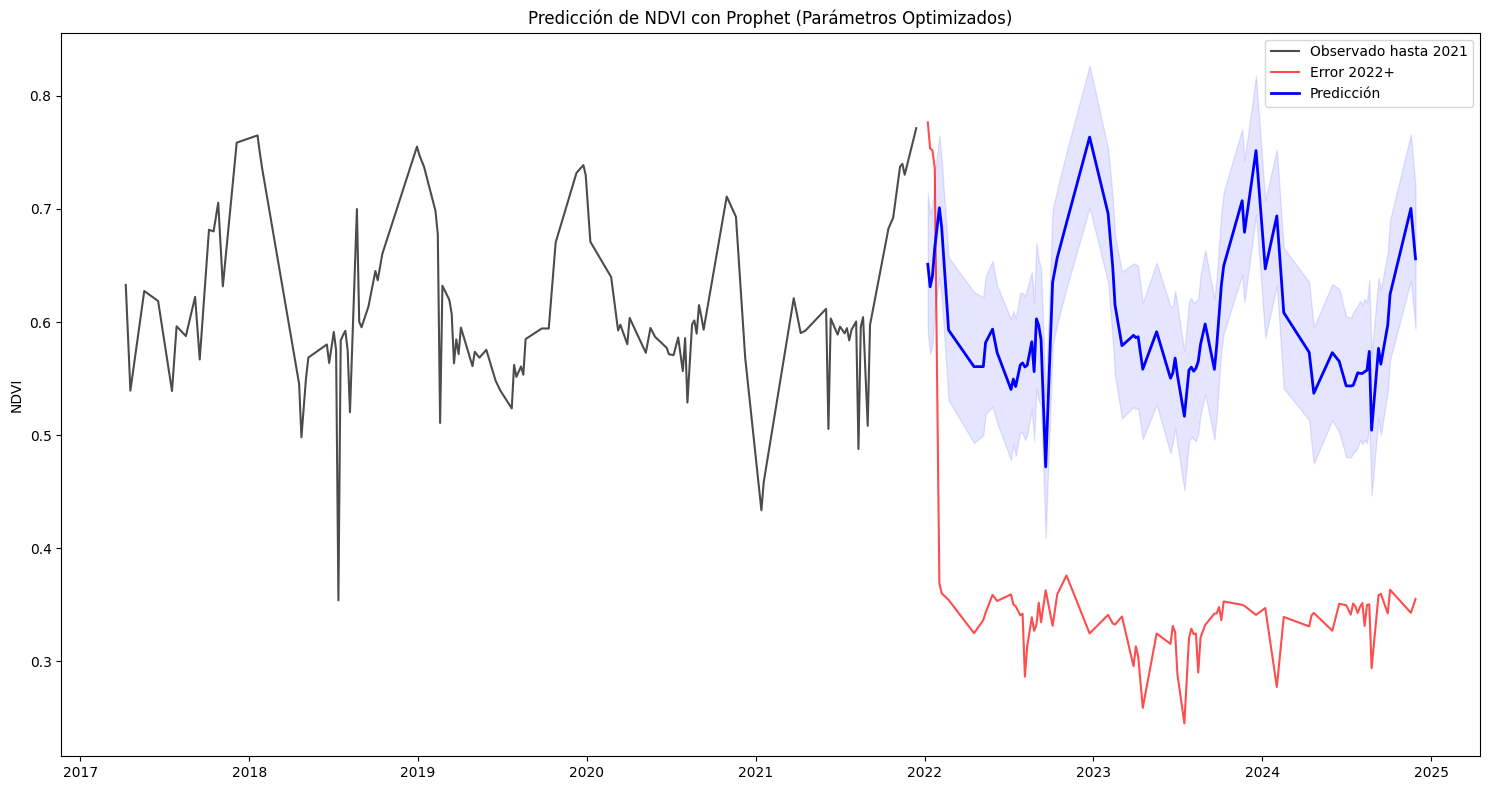

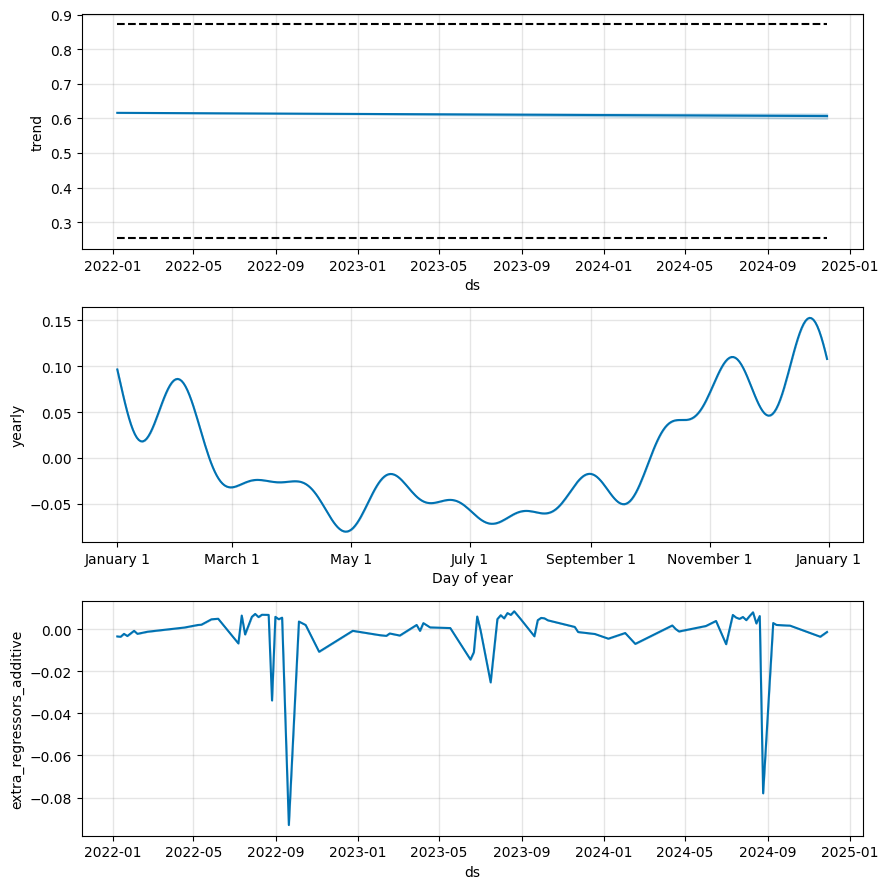


Métricas de error en datos históricos (hasta 2021):
RMSE: 0.048
MAE: 0.032


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

# Preparar los datos para Prophet
df_prophet = df_clean.copy()
df_prophet = df_prophet.rename(columns={'fecha': 'ds', 'ndvi': 'y'})
df_prophet = df_prophet.rename(columns={
    'temperatura': 'temp',
    'precipitacion': 'precip'
})

# Crear modelo con los parámetros optimizados por CV
model = Prophet(
    changepoint_prior_scale=0.20,    # Optimizado
    seasonality_prior_scale=0.1,   # Optimizado
    seasonality_mode='additive',    # Optimizado
    yearly_seasonality=10,
    weekly_seasonality=False,
    daily_seasonality=False,
    growth='logistic'
)

# Establecer límites basados en los datos históricos
df_prophet['cap'] = df_prophet['y'].max() + 0.1
df_prophet['floor'] = max(0, df_prophet['y'].min() - 0.1)

# Añadir los regresores
model.add_regressor('temp', mode='additive', prior_scale=0.03)
model.add_regressor('precip', mode='additive', prior_scale=0.03)

# Ajustar el modelo
model.fit(df_prophet)

# Crear dataframe futuro usando las fechas de df_2022
future = df_2022[['fecha', 'temperatura', 'precipitacion']].copy()
future = future.rename(columns={
    'fecha': 'ds',
    'temperatura': 'temp',
    'precipitacion': 'precip'
})

# Añadir límites al dataframe futuro
future['cap'] = df_prophet['cap'].iloc[0]
future['floor'] = df_prophet['floor'].iloc[0]

# Realizar predicciones
forecast = model.predict(future)

# Visualizar resultados
plt.figure(figsize=(15, 8))

# Datos históricos
sns.lineplot(data=df_prophet, x='ds', y='y', color='black', label='Observado hasta 2021', alpha=0.7)

# Datos reales 2022+
sns.lineplot(data=df_2022, x='fecha', y='ndvi', color='red', label='Error 2022+', alpha=0.7)

# Predicciones
sns.lineplot(data=forecast, x='ds', y='yhat', color='blue', label='Predicción', linewidth=2)

# Intervalo de confianza
plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='blue',
                 alpha=0.1,
                 label='Intervalo de confianza')

plt.xlabel('')
plt.ylabel('NDVI')
plt.title('Predicción de NDVI con Prophet (Parámetros Optimizados)')

plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

# Mostrar componentes del modelo
model.plot_components(forecast)
plt.show()

# Calcular métricas de error solo con los datos históricos (df_prophet)
# Primero hacer predicciones para el período histórico
historical = model.predict(df_prophet)

# Calcular métricas
rmse_historical = np.sqrt(np.mean((historical['yhat'].values - df_prophet['y'].values)**2))
mae_historical = np.mean(np.abs(historical['yhat'].values - df_prophet['y'].values))

print("\nMétricas de error en datos históricos (hasta 2021):")
print(f"RMSE: {rmse_historical:.3f}")
print(f"MAE: {mae_historical:.3f}")

# Guardar resultados
results = pd.DataFrame({
    'fecha': forecast['ds'],
    'ndvi_erroneo': df_2022['ndvi'],
    'ndvi_predicho': forecast['yhat'],
    'prediccion_lower': forecast['yhat_lower'],
    'prediccion_upper': forecast['yhat_upper']
})
results.to_csv('predicciones_ndvi.csv', index=False)

Métricas de error en datos históricos (hasta 2021):
RMSE: 0.055
MAE: 0.038

Las métricas dan excelente, con errores bajos (para algo NDVI) y la semejanza con la media es buen indicador de como deberían de comportarse los datos sin eventos extraordinarios (ej. incendios)

### Sacamos los datos reales de `COPERNICUS/S2_SR_HARMONIZED`:


Total de imágenes procesadas: 85

Primeros registros:
       fecha      ndvi
0 2022-01-08  0.776591
1 2022-01-13  0.753397
2 2022-01-18  0.751893
3 2022-01-23  0.736293
4 2022-02-02  0.729322


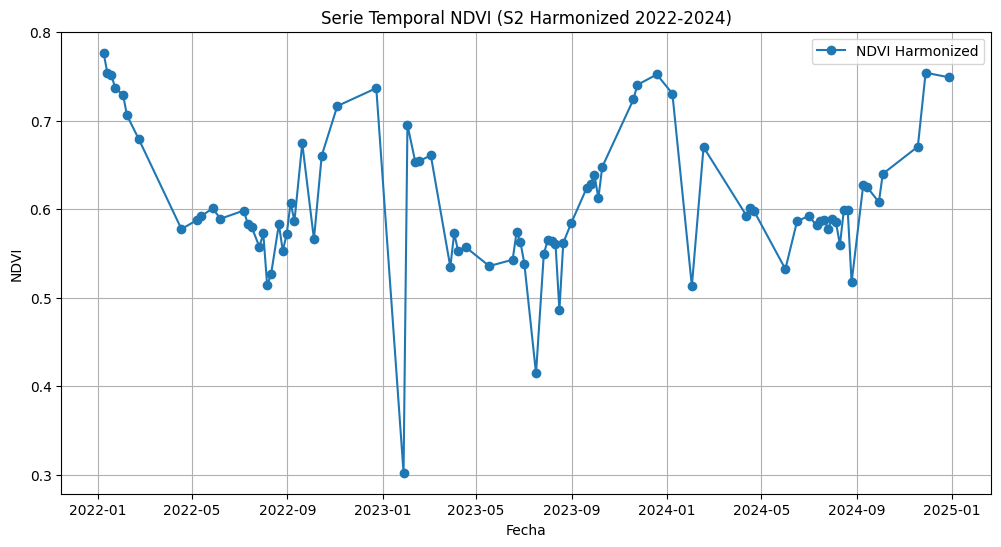

In [ ]:
def get_ndvi_series_harmonized():
    # Colección de Sentinel-2 Harmonized
    s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(roi)
        .filterDate('2022-01-01', '2024-12-31')
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    def calculate_ndvi(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
        stats = ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=10,
            maxPixels=1e9
        ).getInfo()
        return {
            'fecha': date,
            'ndvi': stats.get('NDVI')
        }

    images = s2_collection.toList(s2_collection.size().getInfo())
    resultados = []

    for i in range(images.size().getInfo()):
        try:
            image = ee.Image(images.get(i))
            resultado = calculate_ndvi(image)
            if resultado['ndvi'] is not None:
                resultados.append(resultado)
        except Exception as e:
            print(f"Error: {str(e)}")

    df = pd.DataFrame(resultados)

    # Convertir fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'])

    # Ordenar por fecha
    df = df.sort_values('fecha')

    print(f"Total de imágenes procesadas: {len(df)}")
    return df

# Obtener los datos
df_harmonized = get_ndvi_series_harmonized()

### Metricas finales, con datos reales:

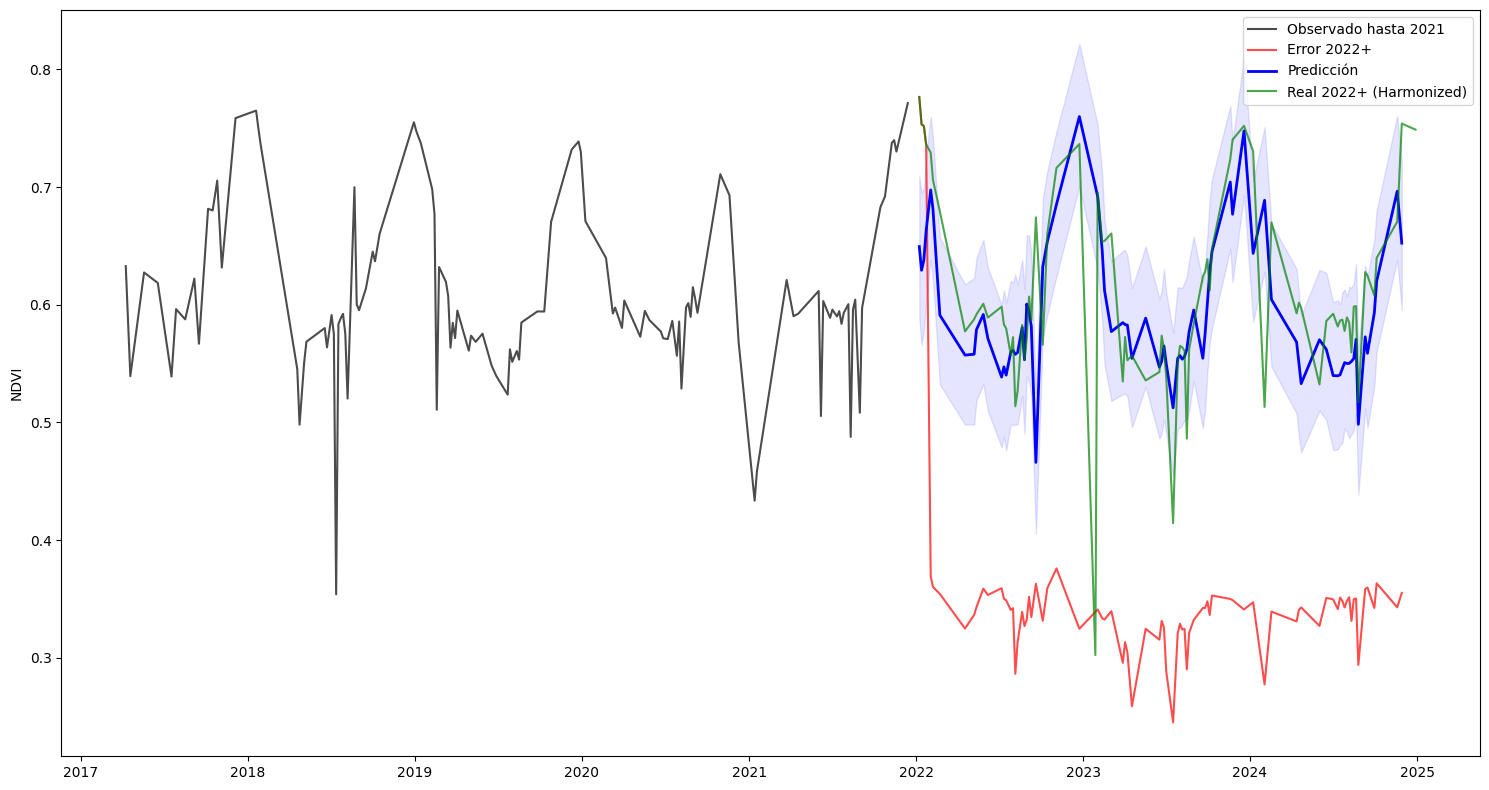

In [ ]:
plt.figure(figsize=(15, 8))

# Datos históricos
sns.lineplot(data=df_prophet, x='ds', y='y', color='black', label='Observado hasta 2021', alpha=0.7)

# Datos erróneos 2022+
sns.lineplot(data=df_2022, x='fecha', y='ndvi', color='red', label='Error 2022+', alpha=0.7)

# Predicciones
sns.lineplot(data=forecast, x='ds', y='yhat', color='blue', label='Predicción', linewidth=2)

# Datos harmonized 2022+
sns.lineplot(data=df_harmonized, x='fecha', y='ndvi', color='green', label='Real 2022+ (Harmonized)', alpha=0.7)

# Intervalo de confianza
plt.fill_between(forecast['ds'],
                forecast['yhat_lower'],
                forecast['yhat_upper'],
                color='blue',
                alpha=0.1,
                label='Intervalo de confianza')

plt.xlabel('')
plt.ylabel('NDVI')

plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

In [ ]:
# Preparar datos para comparación
df_comp = pd.merge(
   forecast[['ds', 'yhat']],
   df_harmonized.rename(columns={'fecha': 'ds'}),
   on='ds',
   how='inner'
)

# Calcular métricas
rmse = np.sqrt(np.mean((df_comp['yhat'] - df_comp['ndvi'])**2))
mae = np.mean(np.abs(df_comp['yhat'] - df_comp['ndvi']))

print("\nMétricas de error comparando con datos reales Harmonized:")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# También podemos calcular el R²
from sklearn.metrics import r2_score
r2 = r2_score(df_comp['ndvi'], df_comp['yhat'])
print(f"R²: {r2:.3f}")


Métricas de error comparando con datos reales Harmonized:
RMSE: 0.054
MAE: 0.038
R²: 0.422


Las metricas:

```plaintext
Métricas de error comparando con datos reales Harmonized:
RMSE: 0.054
MAE: 0.038
R²: 0.422
```
Son muy buenas, para datos tan sensibles al ambiente como el NDVI.
